In [122]:
from __future__ import print_function
import os.path
import dalmatian as dm
import pandas as pd
import sys
sys.path.insert(0, '../JKBio/')
import Datanalytics as da 
import TerraFunction as terra
%load_ext autoreload
from Helper import *
%autoreload 2
import pickle
%load_ext rpy2.ipython
#%load_ext rpy2.ipython
from taigapy import TaigaClient
tc = TaigaClient()
import numpy as np
import itertools

from bokeh.plotting import *
from bokeh.models import HoverTool
output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gseapy
from helper import pyDESeq2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering

from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Loading BokehJS ...

In [ ]:
curl -L -k --user 'pimkin:pqn!@496$' \
https://shiek-db.wistar.upenn.edu/ucscTracks/Pimkin/DNA.tgz -o DNA.tgz &&\
    tar -xvf DNA.tgz &&\
    gsutil -m cp RNA/LYL1 gs://jkobject/Chip_AML/Chip && rm DNA.tgz && rm -r DNA

In [ ]:
a = ! gsutil ls gs://jkobject/Chip_AML/
a

In [3]:
a = a[:-5]

In [7]:
! gcloud auth application-default login

ERROR: (gcloud.auth.application-default.login) unrecognized arguments: -y 

To search the help text of gcloud commands, run:
  gcloud help -- SEARCH_TERMS


In [41]:
sampleset='MAX_AML_2'

In [6]:
terra.uploadFromFolder('jkobject','Chip_AML/',
                       'broad-firecloud-ccle/hg38_RNAseq',samplesetname=sampleset,
                      fformat="fastqR1R2")

please be sure you gave access to your terra email account access to this bucket
> /home/jeremie/JKBio/TerraFunction.py(185)uploadFromFolder()
    184     ipdb.set_trace()
--> 185     df = pd.DataFrame(data)
    186     df = df.set_index("sample_id")

ipdb> n
> /home/jeremie/JKBio/TerraFunction.py(186)uploadFromFolder()
    185     df = pd.DataFrame(data)
--> 186     df = df.set_index("sample_id")
    187     df["participant"] = pd.Series(data['sample_id'], index=data['sample_id'])

ipdb> n
> /home/jeremie/JKBio/TerraFunction.py(187)uploadFromFolder()
    186     df = df.set_index("sample_id")
--> 187     df["participant"] = pd.Series(data['sample_id'], index=data['sample_id'])
    188     wm.upload_samples(df)

ipdb> df
                                                     fastq1  \
sample_id                                                     
BRD4-r1      gs://jkobject/Chip_AML/BRD4-r1_R1_001.fastq.gz   
BRD4-r2      gs://jkobject/Chip_AML/BRD4-r2_R1_001.fastq.gz   
BRD4-r3      gs:/

In [3]:
wm = dm.WorkspaceManager('broad-firecloud-ccle/hg38_RNAseq')

In [8]:
star = wm.get_config("star_v1-0_BETA_cfg")
star

{'deleted': False,
 'inputs': {'star_workflow.star.outSAMattrRGline': '"ID:rg1 SM:sm1"',
  'star_workflow.star.num_threads': '8',
  'star_workflow.star.alignSoftClipAtReferenceEnds': '"Yes"',
  'star_workflow.star.alignMatesGapMax': '1000000',
  'star_workflow.star.outFilterType': '"BySJout"',
  'star_workflow.star.prefix': 'this.name',
  'star_workflow.star.num_preempt': '5',
  'star_workflow.star.alignSJoverhangMin': '8',
  'star_workflow.star.chimOutJunctionFormat': '1',
  'star_workflow.star.memory': '52',
  'star_workflow.star.fastq2': 'this.fastq2',
  'star_workflow.star.outFilterMismatchNoverLmax': '0.1',
  'star_workflow.star.alignIntronMax': '1000000',
  'star_workflow.star.star_index': 'workspace.star_index',
  'star_workflow.star.outSAMattributes': '"NH HI AS nM NM ch"',
  'star_workflow.star.outSAMstrandField': '"intronMotif"',
  'star_workflow.star.limitSjdbInsertNsj': '1200000',
  'star_workflow.star.chimSegmentMin': '15',
  'star_workflow.star.chimJunctionOverhangMin': '

In [11]:
submission_id = wm.create_submission(star['name'], sampleset, 'sample_set',expression='this.samples')

Successfully created submission d16ad400-d060-42c3-b7ed-e860f87a957a.


In [ ]:
terra.waitForSubmission('broad-firecloud-ccle/hg38_RNAseq', submission_id)

In [ ]:
submission_id = wm.create_submission("rsem_v1-0_BETA_cfg", 
                                      sampleset,'sample_set',expression='this.samples')
terra.waitForSubmission('broad-firecloud-ccle/hg38_RNAseq', submission_id)

In [5]:
submission_id = wm.create_submission("rsem_aggregate_results_v1-0_BETA_cfg", 
                                         samplesetname)
terra.waitForSubmission('broad-firecloud-ccle/hg38_RNAseq', submission_id)

NameError: name 'samplesetname' is not defined

In [4]:
results = wm.get_sample_sets().loc[sampleset]
rsem_genes_expected_count = results['rsem_genes_expected_count']

In [5]:
results

samples                            [BRD4-r1, BRD4-r2, BRD4-r3, CDK6-r1, CDK6-r2, ...
rsem_transcripts_isopct            gs://fc-secure-163bcce1-14a1-4cc2-b8f8-ec8bcba...
rsem_transcripts_tpm               gs://fc-secure-163bcce1-14a1-4cc2-b8f8-ec8bcba...
rsem_transcripts_expected_count    gs://fc-secure-163bcce1-14a1-4cc2-b8f8-ec8bcba...
rsem_genes_tpm                     gs://fc-secure-163bcce1-14a1-4cc2-b8f8-ec8bcba...
rsem_genes_expected_count          gs://fc-secure-163bcce1-14a1-4cc2-b8f8-ec8bcba...
Name: MAX_AML_2, dtype: object

In [11]:
! gsutil cp $rsem_genes_expected_count data/

Copying gs://fc-secure-163bcce1-14a1-4cc2-b8f8-ec8bcbabe2da/7fcfa027-1093-456b-9811-c19905978cff/rsem_aggregate_results_workflow/18cf5a35-3707-482f-bb5a-bd295fdf30aa/call-rsem_aggregate_results/MAX_AML_2.rsem_genes_expected_count.txt.gz...
/ [1 files][  3.9 MiB/  3.9 MiB]                                                
Operation completed over 1 objects/3.9 MiB.                                      


In [6]:
file = 'data/'+rsem_genes_expected_count.split('/')[-1]

In [7]:
file

'data/MAX_AML_2.rsem_genes_expected_count.txt.gz'

In [8]:
! gunzip $file

gzip: data/MAX_AML_2.rsem_genes_expected_count.txt.gz: No such file or directory


In [9]:
rsem_genes_expected_count = pd.read_csv(file[:-3], sep='\t')

In [152]:
data = rsem_genes_expected_count.drop("transcript_id(s)",1)

In [153]:
data["gene_id"] = convertGenes(data['gene_id'])[0]

you need access to taiga for this (https://pypi.org/project/taigapy/)
20702 could not be parsed... we don't have all genes already


In [154]:
data=data.set_index('gene_id')

In [155]:
experiments = set([i.split('-')[0] for i in data.columns])
experiments

{'BRD4',
 'CDK6',
 'CEBPa',
 'ELF2',
 'FLI1',
 'GFI1',
 'IKZF1',
 'IRF2BP2',
 'IRF8',
 'LMO2',
 'LYL1',
 'MAX',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MYB',
 'MYC',
 'Non',
 'RUNX1',
 'RUNX2',
 'SPI1',
 'ZEB2',
 'ZMYND8'}

## pre processing 

filter some more

In [156]:
toremove = np.argwhere(data.values.var(1)==0)
toremove.ravel()

array([   24,    70,   127, ..., 58810, 58811, 58812])

In [157]:
toremove.shape

(19537, 1)

In [158]:
data = data.drop(data.iloc[toremove.ravel()].index,0)

In [159]:
data.shape

(39240, 72)

renormalize the data

## Getting the Core TF information

In [19]:
ctf=pd.read_csv('data/CTF.csv',header=None)[0].values.tolist()
ctf

['MYC',
 'MYB',
 'SPI1',
 'RUNX1',
 'GSE1',
 'IRF2BP2',
 'FLI1',
 'ELF2',
 'ZEB2',
 'IKAROS',
 'GFI1',
 'LMO2',
 'CEBPA',
 'MEF2D',
 'MEF2C',
 'IRF8',
 'MEIS1',
 'RUNX2',
 'ETV6',
 'LDB1',
 'RUNX2',
 'SP1',
 'ZMYND8']

In [160]:
genenames = data.index
ctfpos = [i for i, val in enumerate(genenames) if val in ctf]
notctfpos = [i for i, val in enumerate(genenames) if val not in ctf]

We find a CTF not in the dataset

In [21]:
[val for val in ctf if val not in genenames]

['IKAROS']

In [161]:
ctf.remove('IKAROS')

ValueError: list.remove(x): x not in list

## DESEQ ANALYSIS

In [162]:
expe = {}
for val in experiments: 
    expe[val] = [1 if val in col else 0 for col in data.columns]

In [163]:
data = data.reset_index()

In [164]:
experiments.remove('Non')
results = {}

In [165]:
experiments - set(ctf)

{'BRD4', 'CDK6', 'CEBPa', 'IKZF1', 'LYL1', 'MAX'}

In [166]:
experiments

{'BRD4',
 'CDK6',
 'CEBPa',
 'ELF2',
 'FLI1',
 'GFI1',
 'IKZF1',
 'IRF2BP2',
 'IRF8',
 'LMO2',
 'LYL1',
 'MAX',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MYB',
 'MYC',
 'RUNX1',
 'RUNX2',
 'SPI1',
 'ZEB2',
 'ZMYND8'}

In [167]:
for val in experiments:  
    design = pd.DataFrame(index=data.columns[1:], columns=['DMSO','Target'], 
                          data=np.array([expe['Non'],expe[val]]).T)
    design.index = design.index.astype(str).str.replace('-','.')
    deseq = pyDESeq2.pyDESeq2(count_matrix=data, design_matrix = design, 
                              design_formula='~DMSO + Target', gene_column="gene_id")
    deseq.run_deseq()
    deseq.get_deseq_result()
    r = deseq.deseq_result
    r.pvalue = np.nan_to_num(np.array(r.pvalue), 1)
    r.log2FoldChange = np.nan_to_num(np.array(r.log2FoldChange), 0)
    results[val] = r

3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 931 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 933 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 894 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 891 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 926 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 900 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 899 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 894 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 891 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 901 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 115 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 925 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 931 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 945 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 924 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 895 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 883 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 917 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 901 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 937 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



3.2.1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 928 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



## what are most downregulated (volcano)

In [396]:
MS2res.pvalue = np.nan_to_num(np.array(MS2res.pvalue), 1)
MS2res.log2FoldChange = np.nan_to_num(np.array(MS2res.log2FoldChange), 0)
MS2res.gene_id = convertGenes(MS2res.gene_id)[0]
show(volcano(MS2res,tohighlight=ctf))

0 could not be parsed... we don't have all genes already


## CTF (volcano)

In [125]:
results

{}

In [124]:
for val in experiments:
    a = volcano(results[val],tohighlight=ctf,title=val)
    try:
        show(a)
    except RuntimeError:
        show(a)

KeyError: 'ELF2'

In [29]:
data = data.set_index('gene_id')

## any bias in the data

In [129]:
red = PCA(50).fit_transform(data.T)
a = scatter(red, labels=data.columns)

In [130]:
red.shape

(72, 50)

In [131]:
red = TSNE(2,10).fit_transform(red)

In [132]:
a = scatter(red[:,:2], labels=data.columns, radi=10)

In [134]:
show(a)

In [135]:
dataclean = data[data.max(1) > 10].drop(['LMO2-r1','LMO2-r2','LMO2-r3'],1)

In [85]:
for val in grouped(dataclean.columns,3):
    val = list(val)
    dataclean[val[0].split('-')[0]] = dataclean[val].mean(1)
    dataclean = dataclean.drop(val,1)

In [136]:
pca = PCA(20)
red = pca.fit_transform(dataclean.T)

In [137]:
pca.explained_variance_ratio_

array([0.60616093, 0.13332703, 0.08728476, 0.04684083, 0.03093741,
       0.02094898, 0.01471269, 0.01165771, 0.00956246, 0.00827987,
       0.00562868, 0.00426423, 0.00328936, 0.00277748, 0.00203602,
       0.00181748, 0.0014279 , 0.0012324 , 0.00095803, 0.00079218])

In [138]:
a = scatter(red[:,:2], labels=dataclean.columns, radi=4000, title='batch effect RNP')

MAX CEBPa ZEB2 

In [140]:
show(a)

In [99]:
save(a,'data/plots/batcheffect_RNP.html')

'/home/jeremie/AMLproject/data/plots/batcheffect_RNP.html'

## GSEA analysis

In [119]:
res = {}

MEIS1
MYC
BRD4
IRF8
ZMYND8
FLI1
MAX
MYB
RUNX2
CDK6
IKZF1
LMO2
SPI1
ZEB2
IRF2BP2
MEF2C
ELF2
CEBPa
LYL1
MEF2D
RUNX1
GFI1


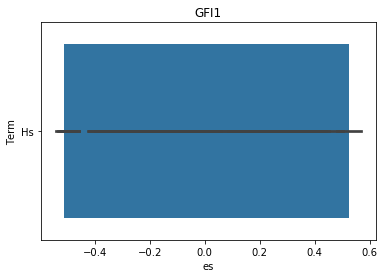

In [127]:
for val in experiments:
    print(val)
    totest = data[[v for v in data.columns if val in v or 'Non' in v]]
    cls = ['Condition' if val in v else 'DMSO' for v in totest.columns]
    res[val] = gseapy.gsea(data=totest, gene_sets='WikiPathways_2013', 
                cls= cls, no_plot=False, processes=6)
    res[val].res2d['Term'] = [i.split('_')[0][:50] for i in res[val].res2d.index]
    
    sns.barplot(data=res[val].res2d.iloc[:25], x="es", y="Term",
                hue_order="geneset_size").set_title(val)

In [130]:
with open('wikipathway', 'wb') as f:
    pickle.dump(res,f)

In [70]:
with open('wikipathway','rb') as f:
    res = pickle.load(f)

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


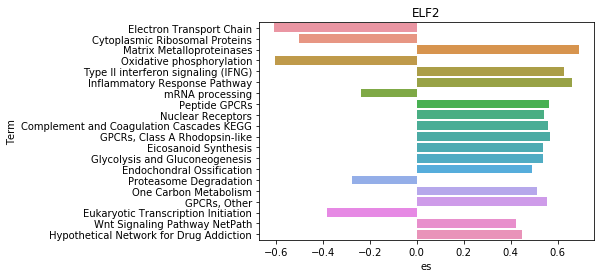

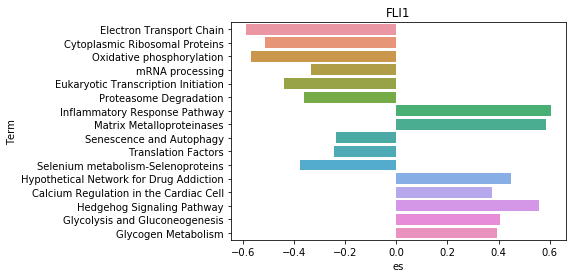

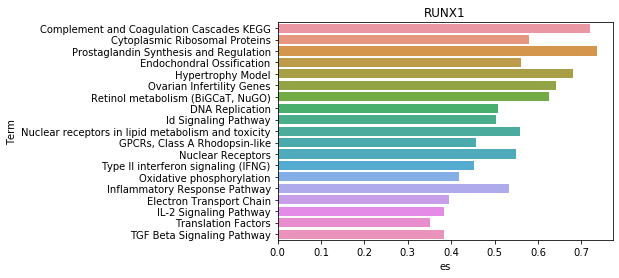

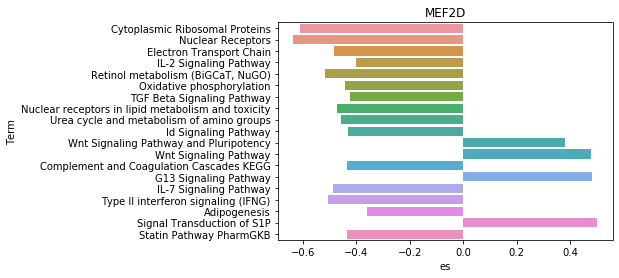

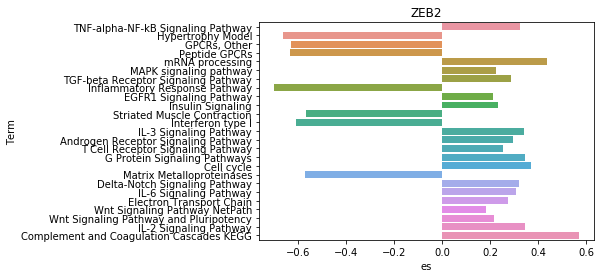

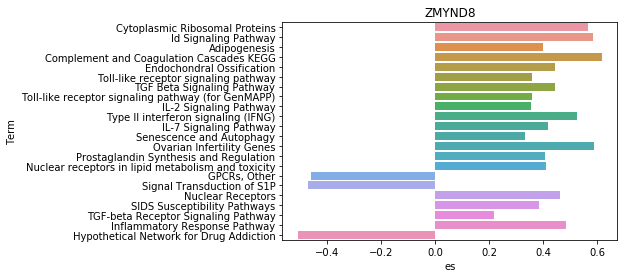

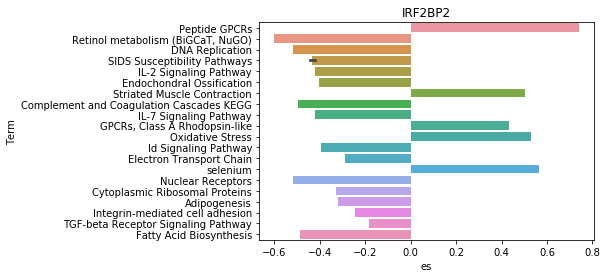

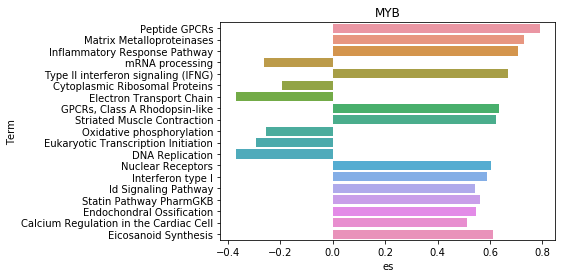

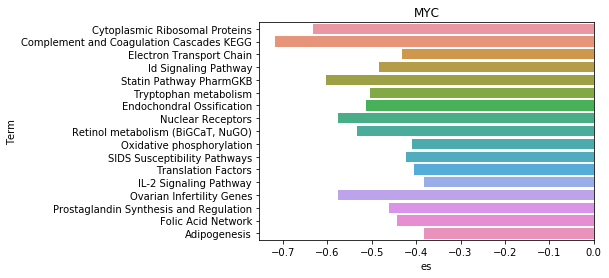

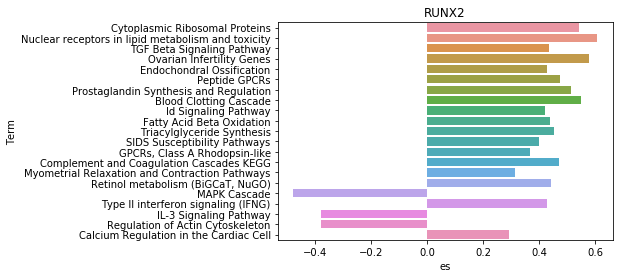

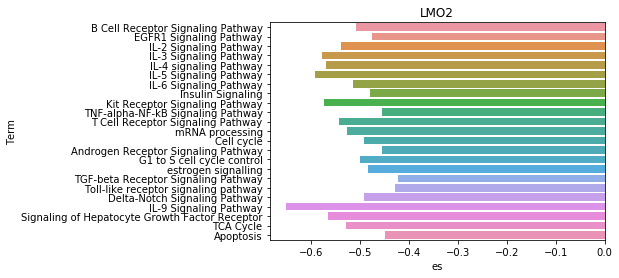

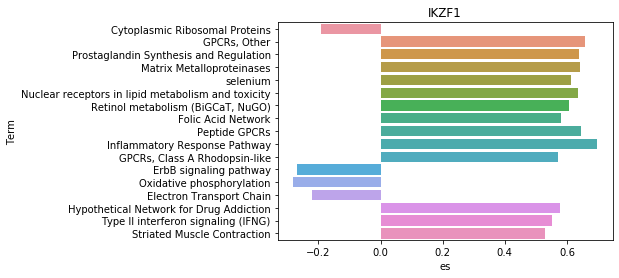

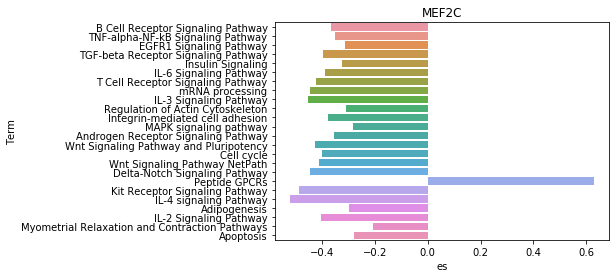

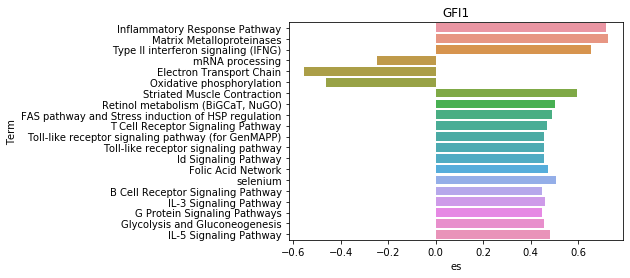

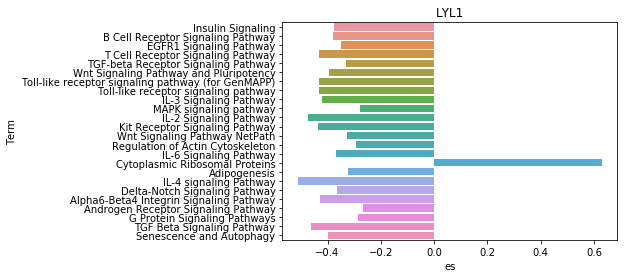

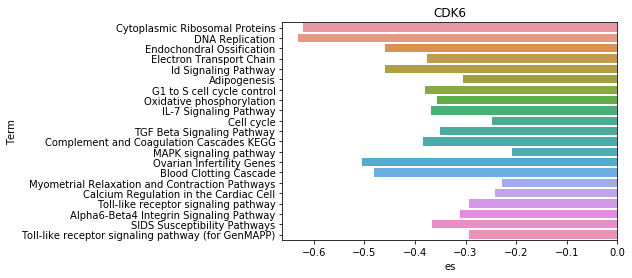

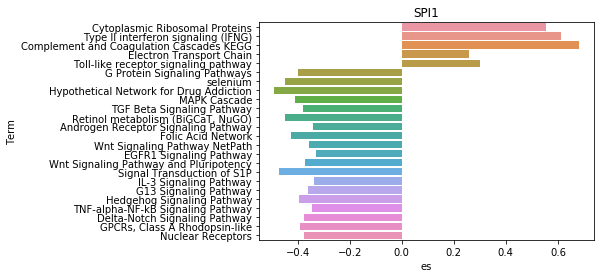

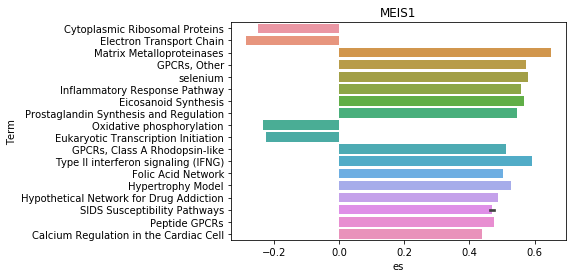

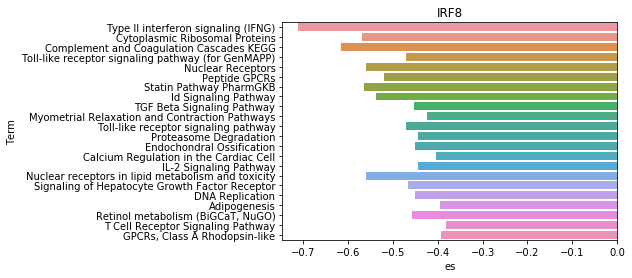

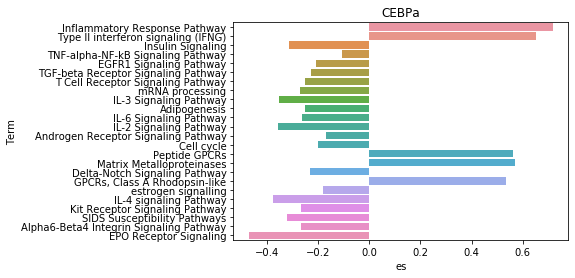

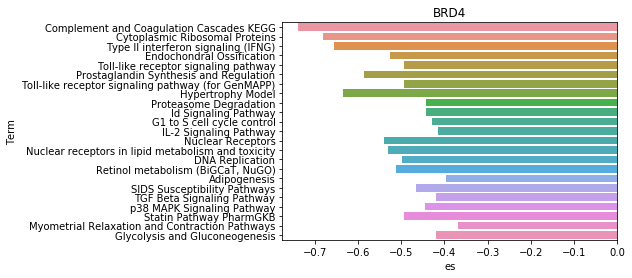

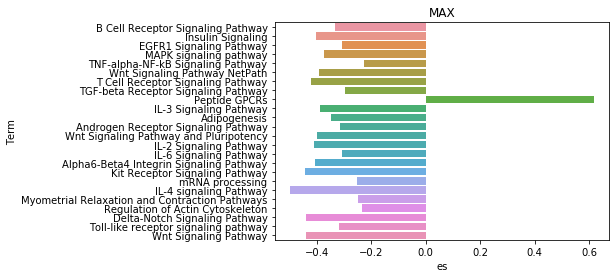

In [71]:
for i, val in enumerate(experiments):
    plt.figure(i)
    res[val].res2d.Term = [' '.join(i.split('_')[1:-2]) for i in res[val].res2d.index]
    sns.barplot(data=res[val].res2d.iloc[:25], x="es", y="Term",
                hue_order="geneset_size").set_title(val)

In [81]:
a = set()
for k, val in res.items():
    a.update(set(val.res2d.index))
a = {i:[0]*len(res) for i in a}
for n,(k, val) in enumerate(res.items()):
    for i,v in val.res2d.iterrows():
        a[i][n] = v.es
res = pd.DataFrame(a, index=res.keys())
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(ax=ax,data=res)

AttributeError: 'Series' object has no attribute 'res2d'

In [141]:
model = AgglomerativeClustering(n_clusters=6,linkage="average", 
                                affinity="cosine", compute_full_tree=True)
labels = model.fit_predict(res)
ii = itertools.count(res.shape[0])
tree = [{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in model.children_]
sort = labels.argsort()
a = plotCorrelationMatrix(res.values[sort],res.index[sort].tolist(),interactive=True)

/home/jeremie/miniconda3/lib/python3.7/site-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/home/jeremie/miniconda3/lib/python3.7/site-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


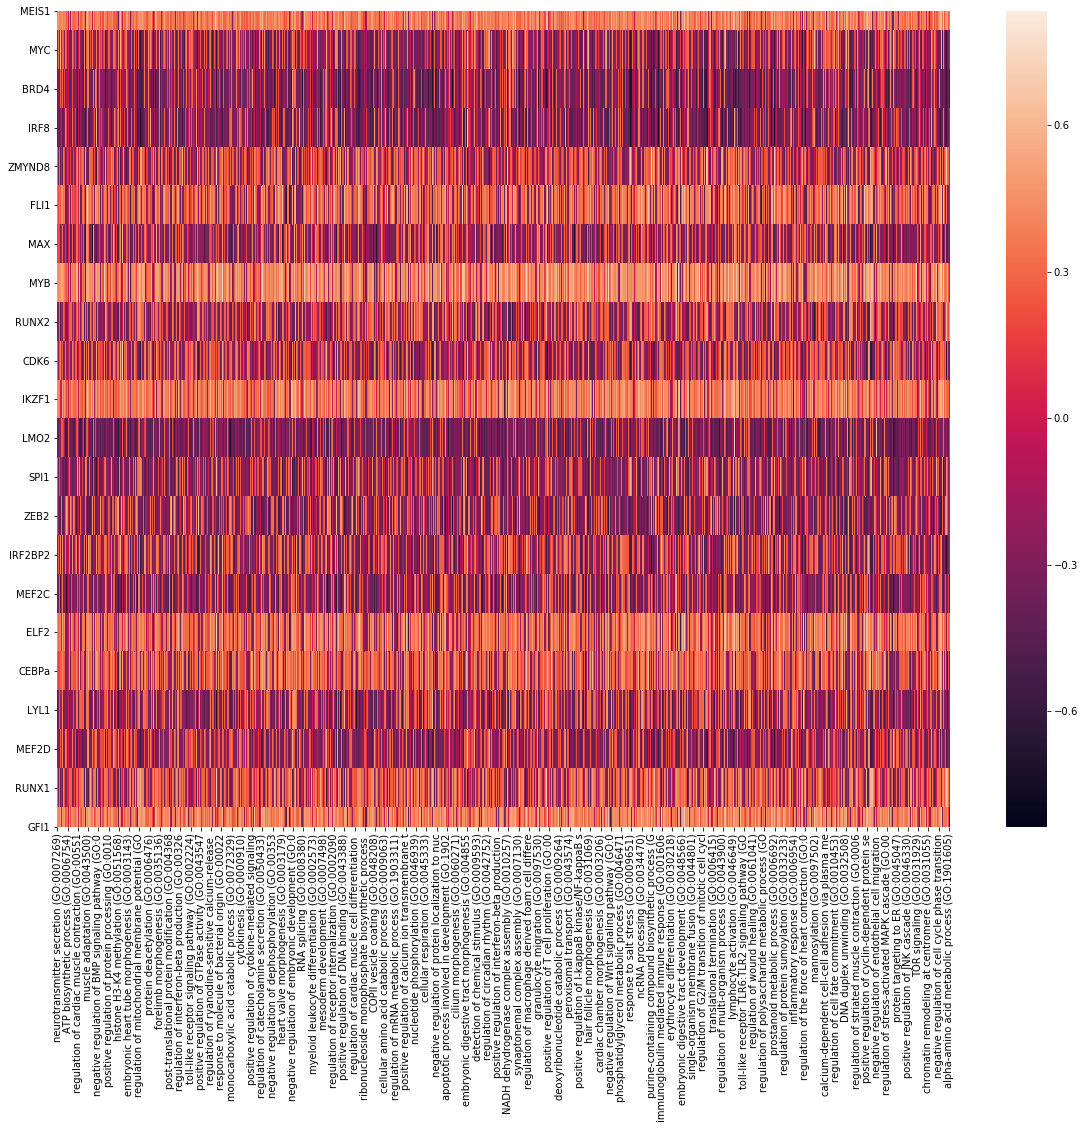

In [82]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(ax=ax,data=res)

In [83]:
fig.savefig("enriched_terms.png")

In [143]:
show(a)

In [ ]:
fi

In [65]:
experiments

{'BRD4',
 'CDK6',
 'CEBPa',
 'ELF2',
 'FLI1',
 'GFI1',
 'IKZF1',
 'IRF2BP2',
 'IRF8',
 'LMO2',
 'LYL1',
 'MAX',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MYB',
 'MYC',
 'RUNX1',
 'RUNX2',
 'SPI1',
 'ZEB2',
 'ZMYND8'}

In [78]:
data

,BRD4-r1,BRD4-r2,BRD4-r3,CDK6-r1,CDK6-r2,CDK6-r3,CEBPa-r1,CEBPa-r2,CEBPa-r3,ELF2-r1,...,RUNX2-r3,SPI1-r1,SPI1-r2,SPI1-r3,ZEB2-r1,ZEB2-r2,ZEB2-r3,ZMYND8-r1,ZMYND8-r2,ZMYND8-r3
gene_id,,,,,,,,,,,,,,,,,,,,,
TSPAN6,0.00,2.00,0.00,1.00,0.00,3.00,0.00,0.00,0.00,0.00,...,0.00,2.00,1.00,1.00,4.00,2.0,1.00,3.00,1.00,1.00
TNMD,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
DPM1,543.00,646.00,700.00,738.00,645.00,687.00,1079.00,1050.00,1149.00,613.00,...,873.00,903.00,749.00,701.00,1107.00,758.0,929.00,521.00,715.00,688.00
SCYL3,158.33,191.89,158.28,205.39,161.19,219.88,303.40,346.63,327.12,195.05,...,207.90,227.20,232.98,224.73,305.21,241.5,276.69,152.57,177.88,206.75
C1orf112,260.67,250.11,293.72,332.61,262.81,242.12,549.60,502.37,571.88,286.95,...,358.10,417.80,354.02,315.27,433.79,295.5,335.31,265.43,375.12,317.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000285991,4.68,9.67,2.86,5.29,6.11,8.85,8.72,12.55,22.22,9.39,...,2.67,19.58,7.44,6.67,0.00,10.9,5.28,4.94,5.68,2.73
ENSG00000285992,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
ENSG00000285993,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00


MEIS1
MYC
BRD4
IRF8
ZMYND8
FLI1
MAX
MYB
RUNX2
CDK6
IKZF1
LMO2
SPI1
ZEB2
IRF2BP2
MEF2C
ELF2
CEBPa
LYL1
MEF2D
RUNX1


/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


GFI1


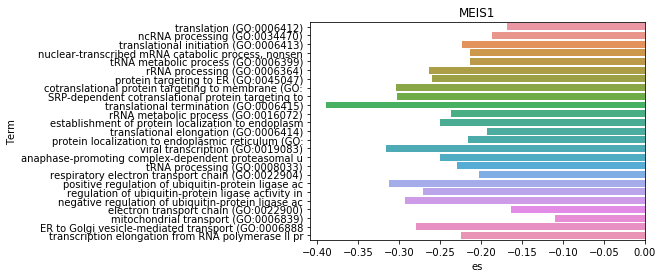

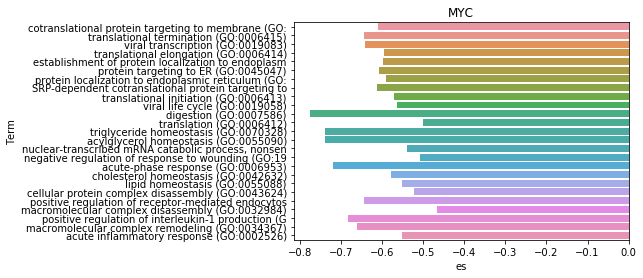

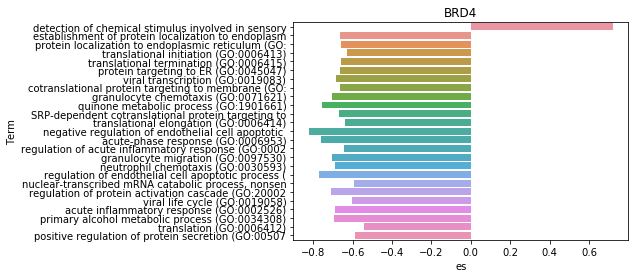

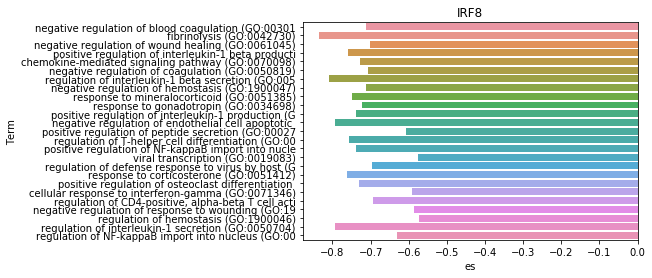

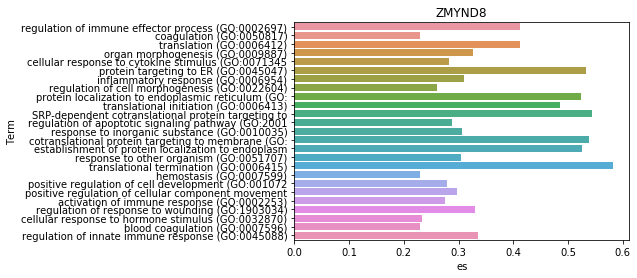

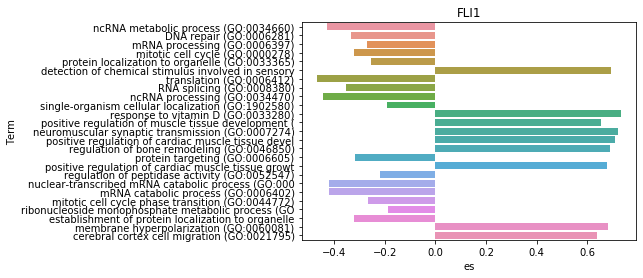

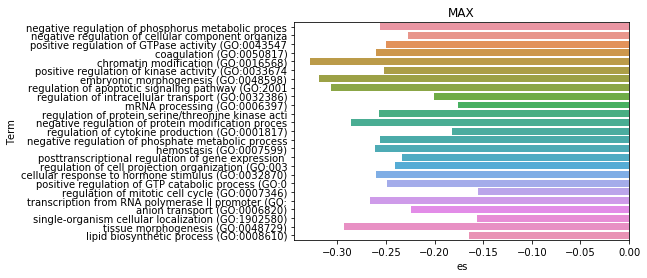

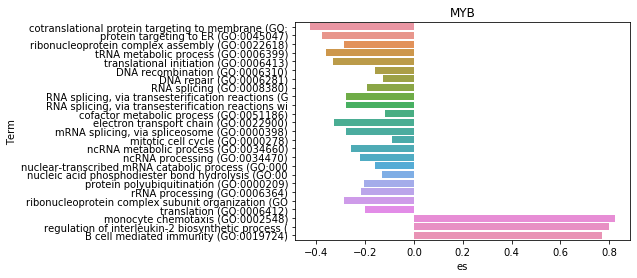

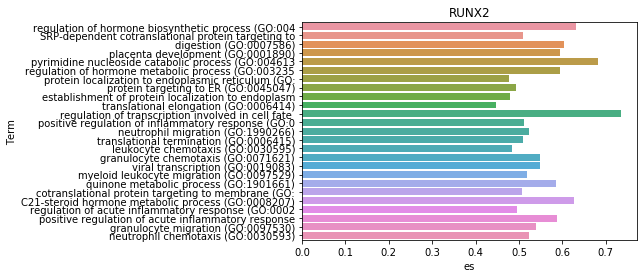

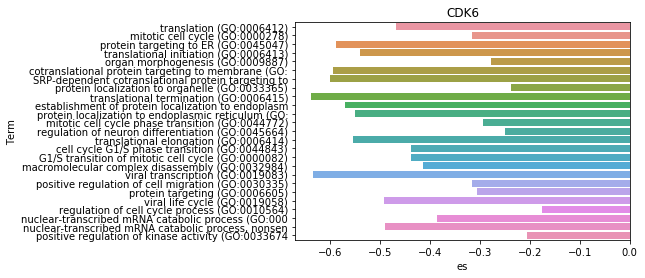

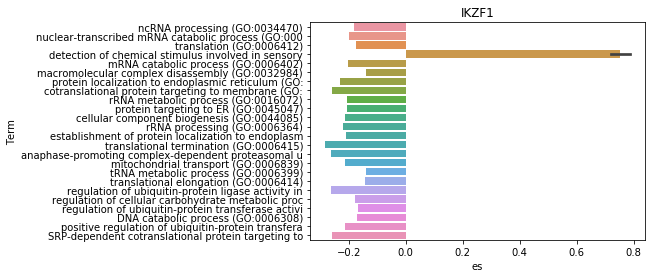

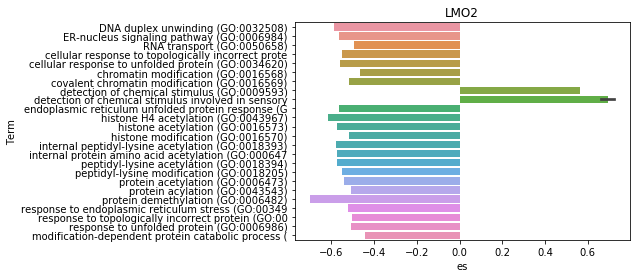

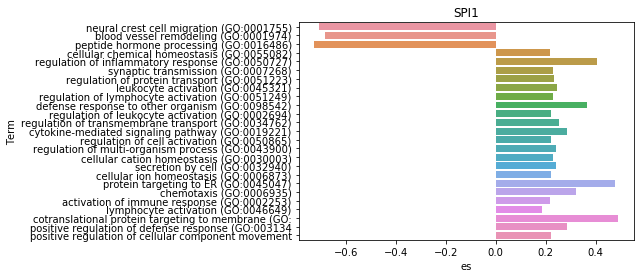

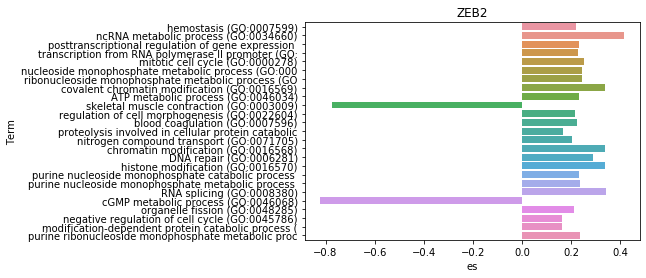

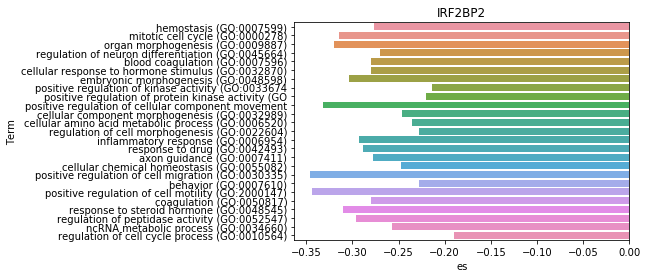

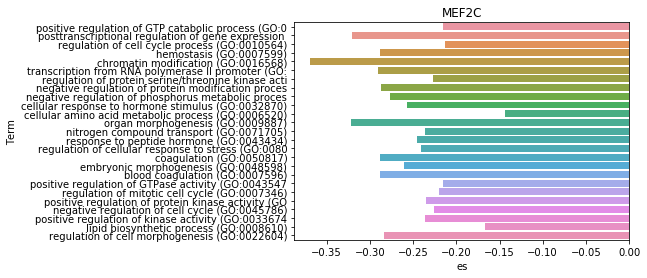

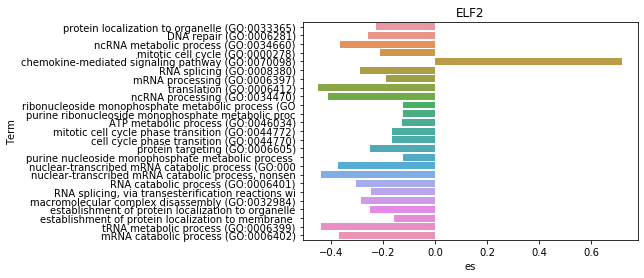

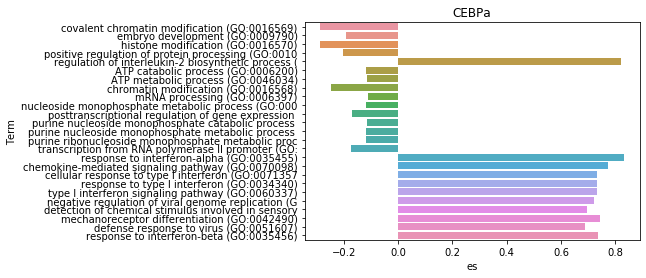

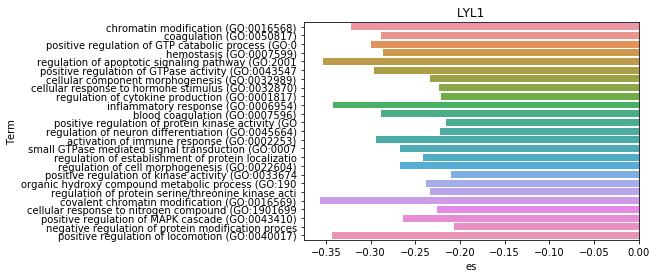

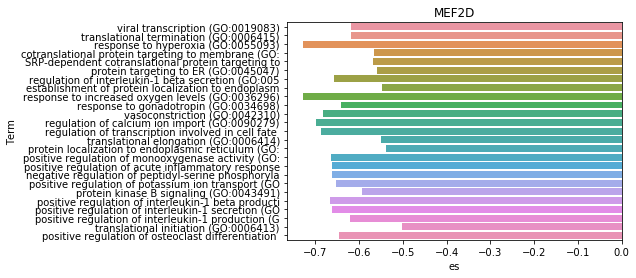

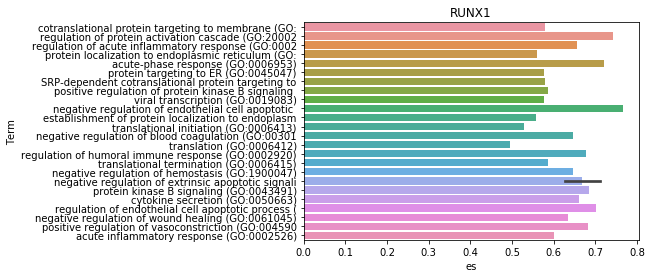

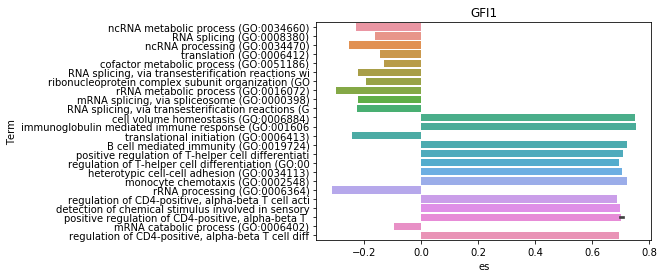

In [140]:
for i, val in enumerate(experiments):
    print(val)
    totest = data[[v for v in data.columns if val in v or 'Non' in v]]
    cls = ['Condition' if val in v else 'DMSO' for v in totest.columns]
    res[val] = gseapy.gsea(data=totest, gene_sets='GO_Biological_Process_2015', 
                cls= cls, no_plot=False, processes=6)
    res[val].res2d['Term'] = [i.split('_')[0][:50] for i in res[val].res2d.index]
    plt.figure(i)
    sns.barplot(data=res[val].res2d.iloc[:25], x="es", y="Term",
                hue_order="geneset_size").set_title(val)

In [141]:
with open('GO_Biological_Process_2015', 'wb') as f:
    pickle.dump(res,f)

In [72]:
with open('GO_Biological_Process_2015','rb') as f:
    res = pickle.load(f)

creating matrices

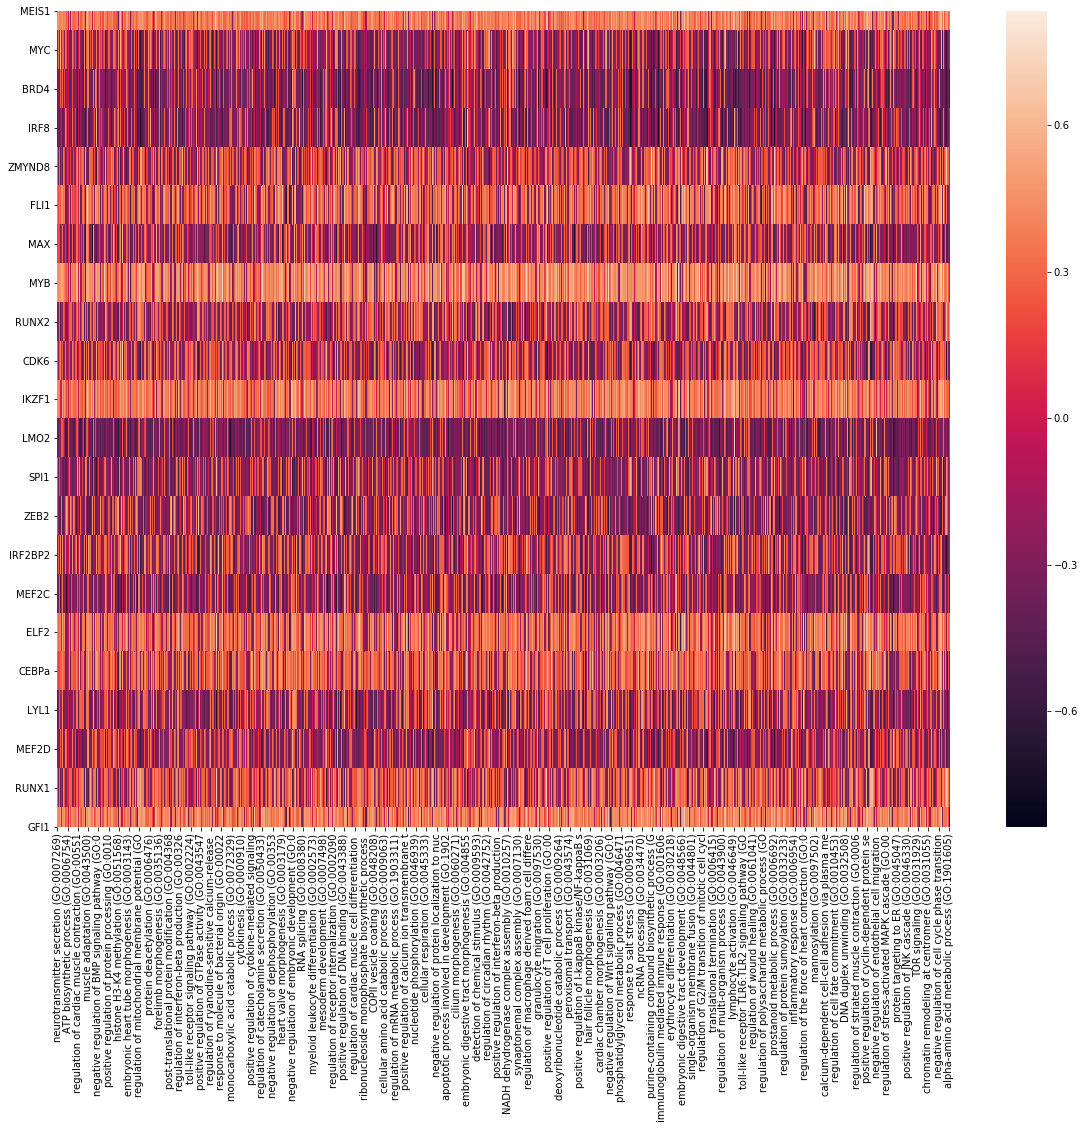

In [73]:
a = set()
for k, val in res.items():
    a.update(set(val.res2d.Term))
a = {i:[0]*len(res) for i in a}
for n,(k, val) in enumerate(res.items()):
    for i,v in val.res2d.iterrows():
        a[v.Term][n] = v.es
res = pd.DataFrame(a, index=res.keys())
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(ax=ax,data=res)

In [74]:
model = AgglomerativeClustering(n_clusters=5,linkage="average", 
                                affinity="cosine", compute_full_tree=True)
labels = model.fit_predict(res)
ii = itertools.count(res.shape[0])
tree = [{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in model.children_]

In [75]:
sort = labels.argsort()

In [144]:
a = plotCorrelationMatrix(res.values[sort],res.index[sort].tolist(),interactive=True)

In [ ]:
show(a)

In [145]:
cluster1= ['LMO2','LYL1','MAX','MEF2C']
cluster2=['GFI1','FLI1','MYB','IKZF1','ELF2','CEBPa','MEIS1']
cluster3=['IRF2BP2','MEF2C','CDK6','MEF2D','IRF8','BRD4','MYC']
cluster4= ['RUNX1','RUNX2','ZMYND8']

In [121]:
res.loc[cluster2].mean().sort_values()

pseudouridine synthesis (GO:0001522)                 -0.510746
mitochondrial respiratory chain complex I assembly   -0.470935
NADH dehydrogenase complex assembly (GO:0010257)     -0.470935
mitochondrial respiratory chain complex I biogenes   -0.470935
spliceosomal complex assembly (GO:0000245)           -0.399071
                                                        ...   
decidualization (GO:0046697)                          0.623559
negative chemotaxis (GO:0050919)                      0.627869
chemokine-mediated signaling pathway (GO:0070098)     0.634745
immunoglobulin mediated immune response (GO:001606    0.657901
regulation of interleukin-2 biosynthetic process (    0.671227
Length: 3311, dtype: float64

In [ ]:
'GO_Molecular_Function_2015',
'GeneSigDB',
'ENCODE_TF_ChIP-seq_2014',
#'Drug_Perturbations_from_GEO_2014',
'GO_Cellular_Component_2015',
'GO_Biological_Process_2015',
'PPI_Hub_Proteins',
'WikiPathways_2013',
'TF-LOF_Expression_from_GEO',
# msig db C2 C6 H http://software.broadinstitute.org/gsea/msigdb/annotate.jsp
# max's crc

## compare to the drop of CTF

In [ ]:
ctf = [
 'BRD4',
 'CDK6',
 'CEBPA',
 'ELF2',
 'FLI1',
 'GFI1',
 'IKZF1',
 'IRF2BP2',
 'IRF8',
 'LMO2',
 'LYL1',
 'MAX',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MYB',
 'MYC',
 'RUNX1',
 'RUNX2',
 'SPI1',
 'ZEB2',
 'ZMYND8'
]

In [168]:
deseq = pd.DataFrame()
for k, val in results.items():
    deseq[k] = val.log2FoldChange
deseq=deseq.T

In [169]:
deseq

,0,1,2,3,4,5,6,7,8,9,...,39230,39231,39232,39233,39234,39235,39236,39237,39238,39239
ELF2,0.443179,-0.008819,-0.664693,-0.053519,0.008946,0.524573,0.496556,-0.206441,-0.302971,-0.032891,...,-0.288036,-0.055355,-0.288034,0.627191,-0.008819,-1.051034,-0.288036,-0.101891,-0.424347,-0.101891
FLI1,-0.189868,0.097581,-0.706206,-0.226584,-0.083854,0.514664,-0.299084,-0.246838,-0.236117,-0.045107,...,-0.181635,1.059326,-0.181634,-0.274710,0.097581,-1.030484,-0.181635,1.012790,-0.317877,0.004509
RUNX1,-0.991938,-0.087752,-0.683421,-0.229634,-0.261417,-0.999370,-2.168175,-0.138693,0.518435,0.258714,...,-0.366970,-0.134288,-0.366967,-0.460047,-0.087752,-0.784925,-0.366969,-0.180824,-1.511991,-0.180824
MEF2D,0.020224,-0.120680,-0.524848,-0.215411,-0.098389,-0.400688,-1.360761,0.227487,0.078872,0.098716,...,-0.399898,-0.167216,-0.399895,-0.492975,-0.120680,-1.893784,-0.399897,-0.213751,0.392284,-0.213751
ZEB2,1.002594,0.015179,0.036458,0.555810,0.103620,-0.473146,-2.309606,-0.306910,-0.217127,0.015349,...,-0.264037,-0.031357,0.744245,-0.357113,1.023460,-1.929752,-0.264037,-0.077892,-1.409318,-0.077892
ZMYND8,0.375459,-0.166375,-0.699632,-0.281487,-0.230902,-0.002502,-3.110083,0.164404,0.045670,0.075654,...,-0.445593,-0.212911,-0.445590,-0.538672,-0.166375,-2.665410,-0.445593,-0.259447,-1.587900,-0.259447
IRF2BP2,-0.518695,-0.165729,-0.402650,-0.015260,-0.535211,-0.589806,-1.969961,0.219962,0.423285,-0.080482,...,-0.444947,-0.212265,-0.444944,-0.538026,-0.165729,-0.212198,-0.444947,-0.258801,-1.585821,-0.258801
MYB,0.195704,-0.303742,-0.555825,-0.096795,-0.800663,0.899889,1.384164,-0.187739,-0.020041,-0.252804,...,-0.582962,-0.350278,-0.582957,-0.676042,-0.303742,-1.036216,0.425328,-0.396814,1.940116,-0.396814
MYC,-1.045935,-0.134801,-0.571926,-0.206067,-0.228730,0.183479,-3.015503,0.038872,0.094934,0.072079,...,-0.414019,-0.181337,-0.414016,-0.507097,-0.134801,-2.028405,-0.414018,-0.227872,-0.547994,-0.227872
RUNX2,0.038713,-0.176368,-0.540146,-0.139385,-0.217753,-0.537471,-1.533546,0.071116,0.193658,0.113019,...,-0.455586,-0.222903,-0.455582,-0.548665,-0.176368,-2.114027,-0.455585,-0.269439,0.344074,-0.269439


In [174]:
a = plotCorrelationMatrix(a,
                          deseq.index[sort].tolist(),interactive=True)

TypeError: unsupported operand type(s) for /: 'Figure' and 'int'

In [181]:
ctf[11] = 'CEBPa'
ctf[]

In [182]:
ctf

['MYC',
 'MYB',
 'SPI1',
 'RUNX1',
 'GSE1',
 'IRF2BP2',
 'FLI1',
 'ELF2',
 'ZEB2',
 'GFI1',
 'LMO2',
 'CEBPa',
 'MEF2D',
 'MEF2C',
 'IRF8',
 'MEIS1',
 'RUNX2',
 'ETV6',
 'LDB1',
 'RUNX2',
 'SP1',
 'ZMYND8']

dropping ETV6 SP1  GSE1 LDB1

In [189]:
deseq.loc[['MYC',
 'MYB',
 'SPI1',
 'RUNX1',
 'IRF2BP2',
 'FLI1',
 'ELF2',
 'ZEB2',
 'GFI1',
 'LMO2',
 'CEBPa',
 'MEF2D',
 'MEF2C',
 'IRF8',
 'MEIS1',
 'RUNX2',
 'RUNX2',
 'ZMYND8']]

,0,1,2,3,4,5,6,7,8,9,...,39230,39231,39232,39233,39234,39235,39236,39237,39238,39239
MYC,-1.045935,-0.134801,-0.571926,-0.206067,-0.228730,0.183479,-3.015503,0.038872,0.094934,0.072079,...,-0.414019,-0.181337,-0.414016,-0.507097,-0.134801,-2.028405,-0.414018,-0.227872,-0.547994,-0.227872
MYB,0.195704,-0.303742,-0.555825,-0.096795,-0.800663,0.899889,1.384164,-0.187739,-0.020041,-0.252804,...,-0.582962,-0.350278,-0.582957,-0.676042,-0.303742,-1.036216,0.425328,-0.396814,1.940116,-0.396814
SPI1,-0.281017,-0.409426,-0.633121,-0.144880,-0.278759,-0.628394,-1.879554,0.339474,-0.069525,-0.093946,...,-0.688647,-0.455962,-0.688641,-0.781728,-0.409426,-1.403529,-0.688646,-0.502497,-1.825487,-0.502497
RUNX1,-0.991938,-0.087752,-0.683421,-0.229634,-0.261417,-0.999370,-2.168175,-0.138693,0.518435,0.258714,...,-0.366970,-0.134288,-0.366967,-0.460047,-0.087752,-0.784925,-0.366969,-0.180824,-1.511991,-0.180824
IRF2BP2,-0.518695,-0.165729,-0.402650,-0.015260,-0.535211,-0.589806,-1.969961,0.219962,0.423285,-0.080482,...,-0.444947,-0.212265,-0.444944,-0.538026,-0.165729,-0.212198,-0.444947,-0.258801,-1.585821,-0.258801
FLI1,-0.189868,0.097581,-0.706206,-0.226584,-0.083854,0.514664,-0.299084,-0.246838,-0.236117,-0.045107,...,-0.181635,1.059326,-0.181634,-0.274710,0.097581,-1.030484,-0.181635,1.012790,-0.317877,0.004509
ELF2,0.443179,-0.008819,-0.664693,-0.053519,0.008946,0.524573,0.496556,-0.206441,-0.302971,-0.032891,...,-0.288036,-0.055355,-0.288034,0.627191,-0.008819,-1.051034,-0.288036,-0.101891,-0.424347,-0.101891
ZEB2,1.002594,0.015179,0.036458,0.555810,0.103620,-0.473146,-2.309606,-0.306910,-0.217127,0.015349,...,-0.264037,-0.031357,0.744245,-0.357113,1.023460,-1.929752,-0.264037,-0.077892,-1.409318,-0.077892
GFI1,0.002155,-0.242367,-0.690804,-0.056343,-0.076962,0.552928,0.853906,-0.405172,-0.239352,0.184828,...,-0.521586,-0.288903,-0.521582,0.393638,-0.242367,-1.682973,-0.521585,-0.335439,1.596505,-0.335439
LMO2,3.309658,2.094987,3.125021,-0.142285,0.982885,-0.859725,2.088849,-0.002987,-0.443565,-0.775733,...,5.299727,2.048451,5.634861,5.267451,2.094987,4.900911,5.118718,3.010196,2.386945,5.087380


In [ ]:
show(a)

In [193]:
deseq_ctf = deseq.loc[['MYC',
 'MYB',
 'SPI1',
 'RUNX1',
 'IRF2BP2',
 'FLI1',
 'ELF2',
 'ZEB2',
 'GFI1',
 'LMO2',
 'CEBPa',
 'MEF2D',
 'MEF2C',
 'IRF8',
 'MEIS1',
 'RUNX2',
 'ZMYND8']]
model = AgglomerativeClustering(n_clusters=7,linkage="average", 
                                affinity="cosine", compute_full_tree=True)
labels = model.fit_predict(deseq_ctf)
ii = itertools.count(deseq_ctf.shape[0])
tree = [{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in model.children_]
sort = labels.argsort()
a = deseq_ctf.values[sort]
a = plotCorrelationMatrix(a, deseq_ctf.index[sort].tolist(),interactive=True)

/home/jeremie/miniconda3/lib/python3.7/site-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/home/jeremie/miniconda3/lib/python3.7/site-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


In [195]:
show(a)

In [171]:
model = AgglomerativeClustering(n_clusters=7,linkage="average", 
                                affinity="cosine", compute_full_tree=True)
labels = model.fit_predict(deseq)
ii = itertools.count(deseq.shape[0])
tree = [{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in model.children_]
sort = labels.argsort()
a = deseq.values[sort]
a = plotCorrelationMatrix(a, deseq.index[sort].tolist(),interactive=True)

/home/jeremie/miniconda3/lib/python3.7/site-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/home/jeremie/miniconda3/lib/python3.7/site-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


In [173]:
show(a)

tsne, pca, clustering accross TF, CRC, most var genes, both ways.